# Adjusted

This is a test document

Next up: importing important packages

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pathlib
import glob
import PIL

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow import keras

Import images

In [2]:
adjusted_data_dir = './Adjusted_185'
adjusted_data_dir = pathlib.Path(adjusted_data_dir)

adjusted_test_data_dir = './TestAdjusted'
adjusted_test_data_dir = pathlib.Path(adjusted_test_data_dir)

To check if it worked, print count images

In [3]:
image_count = len(list(adjusted_data_dir.glob('*/*.png')))
print(image_count)
image_count = len(list(adjusted_test_data_dir.glob('*/*.png')))
print(image_count)

402
48


Also some visual examples

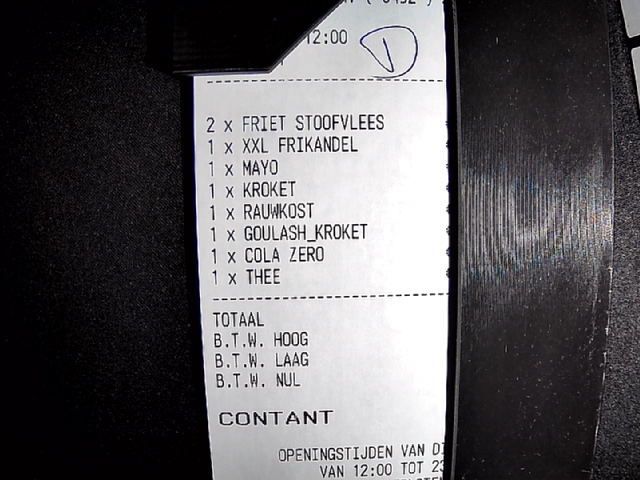

In [4]:
adjusted = list(adjusted_data_dir.glob('adjusted/*'))
PIL.Image.open(str(adjusted[-1]))

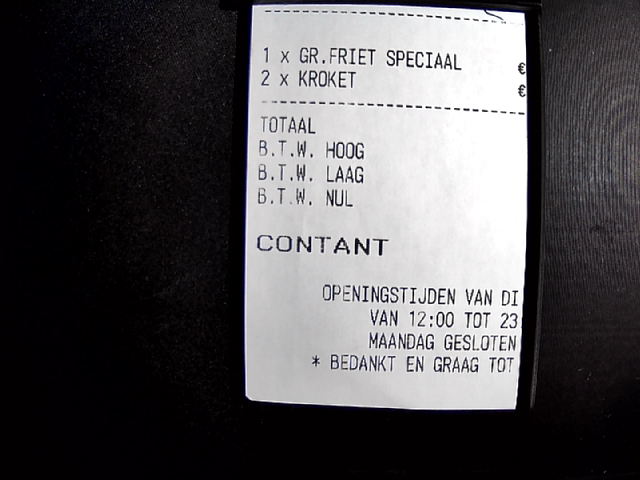

In [5]:
normal = list(adjusted_data_dir.glob('normal/*'))
PIL.Image.open(str(normal[-1]))

Next up: define image settings and divide images into train and validation groups

In [6]:
batch_size = 32
img_height = 240
img_width = 240

In [7]:
train_ads = tf.keras.utils.image_dataset_from_directory(
  adjusted_data_dir,
  validation_split=0.2,
  subset="training",
  seed=69,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ads = tf.keras.utils.image_dataset_from_directory(
  adjusted_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=420,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 402 files belonging to 2 classes.
Using 322 files for training.
Found 402 files belonging to 2 classes.
Using 80 files for validation.


Double check if works

In [8]:
class_names = train_ads.class_names
print(class_names)

['adjusted', 'normal']


Show some data from training set

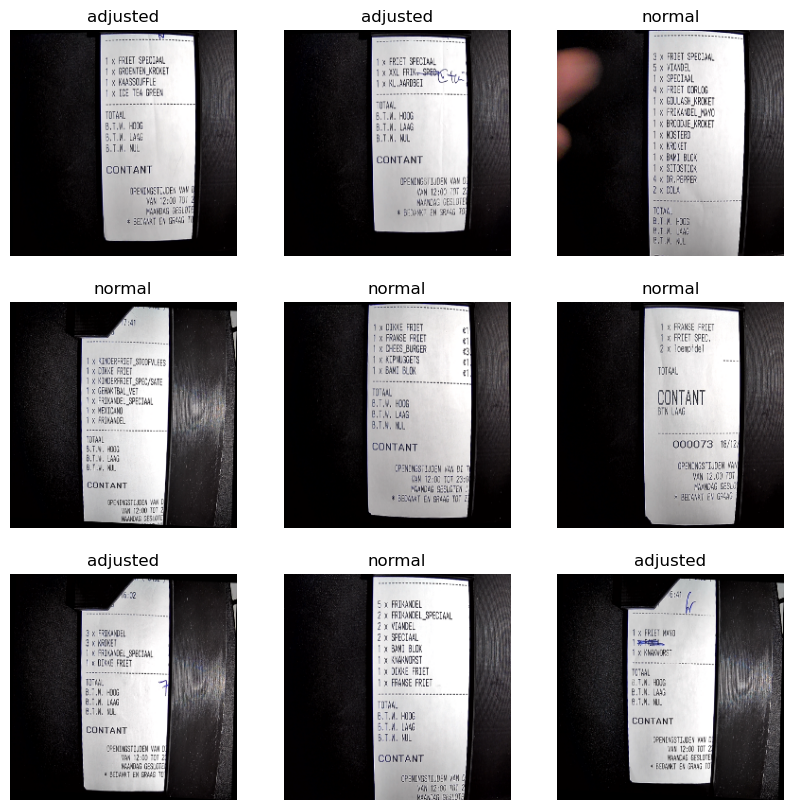

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ads.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Cache so amount will not become a bottleneck
runs executions and preprocesses while training

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ads = train_ads.cache().shuffle(420).prefetch(buffer_size=AUTOTUNE)
val_ads = val_ads.cache().prefetch(buffer_size=AUTOTUNE)

Colors (rgb, 0-255) mess with the AI because of the large numbers, so change this to 0-1

In [11]:
normalization_layer = layers.Rescaling(1./255)

You can apply it to the dataset by calling Dataset.map:

In [12]:
normalized_ads = train_ads.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ads))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
0.0 1.0


create model

In [13]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

compile

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

see summary of the model

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 240, 240, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 240, 240, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 120, 120, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 60, 60, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        1

Finally, train

In [16]:
epochs=15
history = model.fit(
  train_ads,
  validation_data=val_ads,
  epochs=epochs
)

Epoch 1/15
11/11 [==============================] - 5s 376ms/step - loss: 1.3704 - accuracy: 0.5404 - val_loss: 0.6460 - val_accuracy: 0.6750
Epoch 2/15
11/11 [==============================] - 4s 344ms/step - loss: 0.6259 - accuracy: 0.6739 - val_loss: 0.6072 - val_accuracy: 0.6750
Epoch 3/15
11/11 [==============================] - 4s 329ms/step - loss: 0.6102 - accuracy: 0.6739 - val_loss: 0.5736 - val_accuracy: 0.6750
Epoch 4/15
11/11 [==============================] - 4s 326ms/step - loss: 0.5787 - accuracy: 0.6832 - val_loss: 0.5299 - val_accuracy: 0.7125
Epoch 5/15
11/11 [==============================] - 4s 351ms/step - loss: 0.5336 - accuracy: 0.7298 - val_loss: 0.4863 - val_accuracy: 0.7375
Epoch 6/15
11/11 [==============================] - 4s 340ms/step - loss: 0.4931 - accuracy: 0.7484 - val_loss: 0.4448 - val_accuracy: 0.8000
Epoch 7/15
11/11 [==============================] - 4s 339ms/step - loss: 0.4976 - accuracy: 0.7733 - val_loss: 0.4745 - val_accuracy: 0.7750
Epoch 

In [17]:
test_ads = tf.keras.utils.image_dataset_from_directory(
  adjusted_test_data_dir,
  seed=69,
  image_size=(img_height, img_width),
  batch_size=batch_size)

results = model.evaluate(
  train_ads,
  batch_size=batch_size
)
print("test loss, test acc:", results)

Found 48 files belonging to 2 classes.
11/11 [==============================] - 1s 65ms/step - loss: 0.0723 - accuracy: 0.9876
test loss, test acc: [0.07227801531553268, 0.9875776171684265]


Visualize

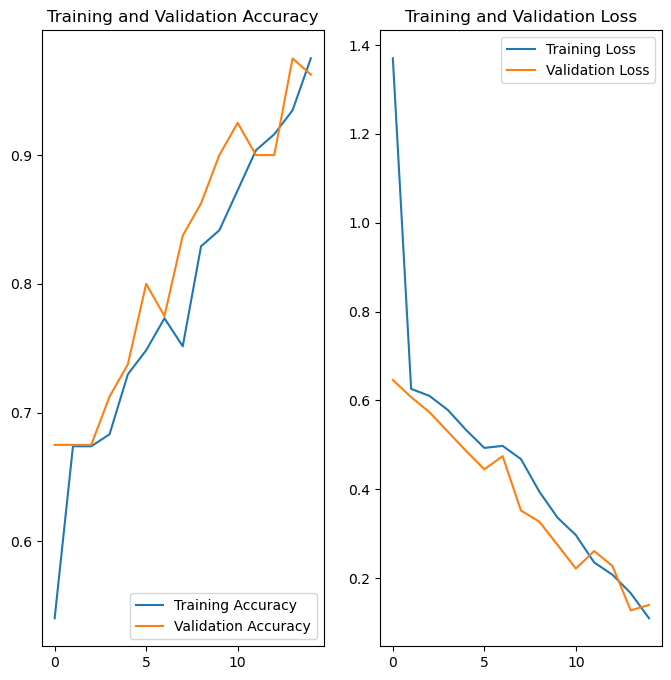

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

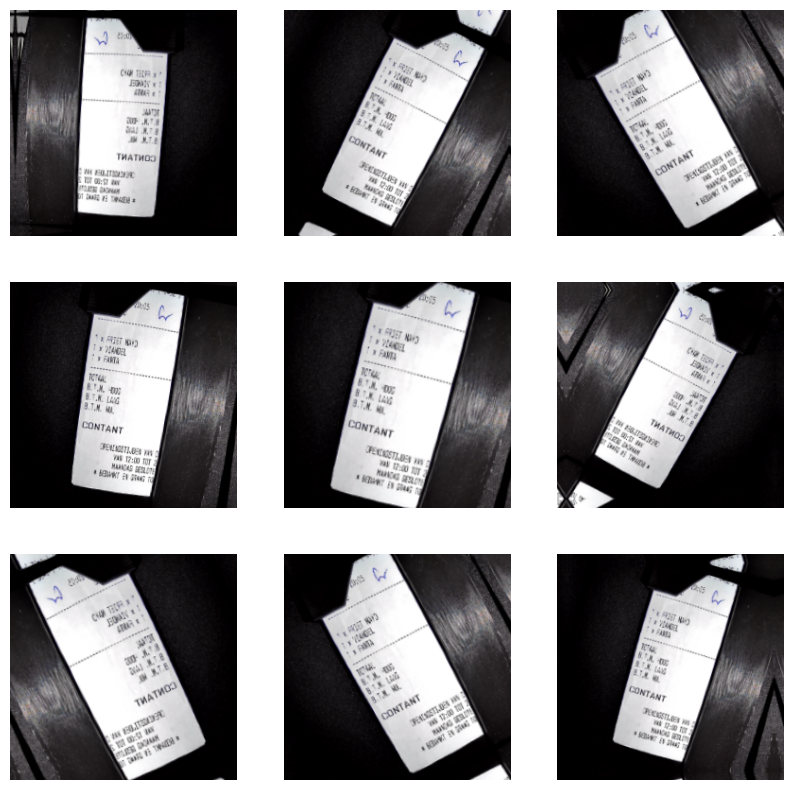

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_ads.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [21]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 240, 240, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 240, 240, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 240, 240, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 120, 120, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 120, 120, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 60, 60, 32)       0         
 2D)                                                  

In [24]:
epochs = 15
history = model.fit(
  train_ads,
  validation_data=val_ads,
  epochs=epochs
)

Epoch 1/15
11/11 [==============================] - 6s 431ms/step - loss: 1.0568 - accuracy: 0.5994 - val_loss: 0.6242 - val_accuracy: 0.6750
Epoch 2/15
11/11 [==============================] - 4s 386ms/step - loss: 0.6392 - accuracy: 0.6739 - val_loss: 0.6462 - val_accuracy: 0.6750
Epoch 3/15
11/11 [==============================] - 4s 386ms/step - loss: 0.6420 - accuracy: 0.6739 - val_loss: 0.6356 - val_accuracy: 0.6750
Epoch 4/15
11/11 [==============================] - 4s 390ms/step - loss: 0.6356 - accuracy: 0.6739 - val_loss: 0.6208 - val_accuracy: 0.6750
Epoch 5/15
11/11 [==============================] - 4s 382ms/step - loss: 0.6370 - accuracy: 0.6739 - val_loss: 0.6339 - val_accuracy: 0.6750
Epoch 6/15
11/11 [==============================] - 4s 384ms/step - loss: 0.6392 - accuracy: 0.6739 - val_loss: 0.6143 - val_accuracy: 0.6750
Epoch 7/15
11/11 [==============================] - 4s 400ms/step - loss: 0.6383 - accuracy: 0.6739 - val_loss: 0.6217 - val_accuracy: 0.6750
Epoch 

check

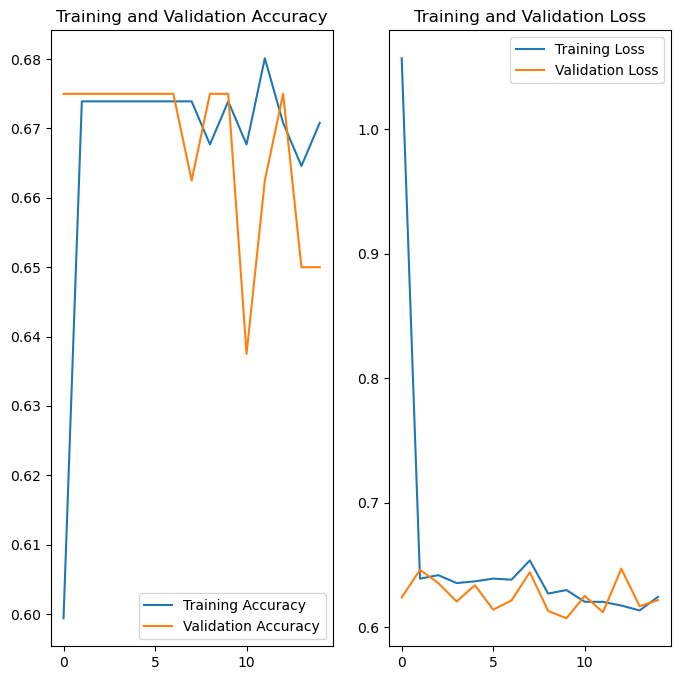

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Check with new data

In [26]:
print(model)

In [27]:
path='Weights_folder/Weights'
model.save_weights(path)

In [28]:
model.save('adjustedModel.h5')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 240, 240, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 240, 240, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 240, 240, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 120, 120, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 120, 120, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 60, 60, 32)       0         
 2D)                                                  